In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## Dataset creation for training, validation and testing

In [2]:
# creating a train_dataset for training (First input argument is an absolute path of training images)  
train_dataset = tf.keras.utils.image_dataset_from_directory('/home/ari/Fretello/Guitar_challenge/GuitarDatasetChallenge/train',
                                                            shuffle=True, batch_size= 32, image_size=(160,160))

Found 75 files belonging to 2 classes.


In [3]:
# Creating a val_dataset for testing (First input argument is an absolute path of validation images)  
val_dataset = tf.keras.utils.image_dataset_from_directory('/home/ari/Fretello/Guitar_challenge/GuitarDatasetChallenge/val',
                                                            shuffle=True, batch_size= 32, image_size=(160,160))

Found 14 files belonging to 2 classes.


In [4]:
# Creating a val_dataset for testing (First input argument is an absolute path of test images)
#used few images from internet
test_dataset = tf.keras.utils.image_dataset_from_directory('/home/ari/Fretello/Guitar_challenge/GuitarDatasetChallenge/test',
                                                            shuffle=True, batch_size= 32, image_size=(160,160))

Found 6 files belonging to 2 classes.


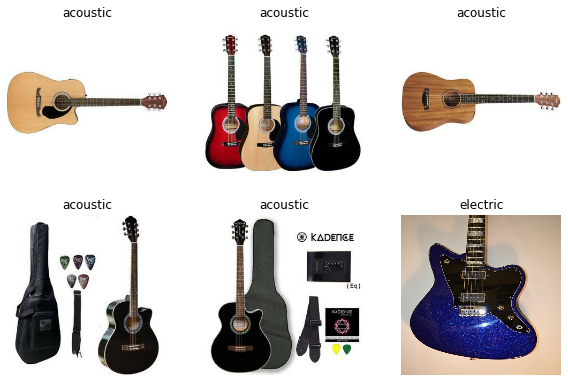

In [5]:
# Plotting images from train_dataset for visualization purpose
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [6]:
#to load images from disk without having I/O become blocking
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)


## Data augmentation and pre-processing

In [7]:
# data aumentation for increasing dastaset and train some additional features to the model
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


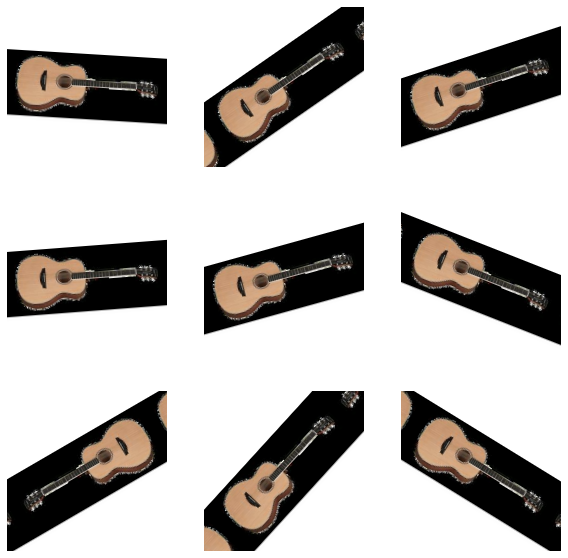

In [8]:
# plotting first augmented image to get better insights about augmented images
for image, _ in val_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [9]:
# We can also add augmented images for training fro that we use this 'preprocess-input' method
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Model selection
We will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

In [10]:
# By specifying the include_top=False argument, we load a network that doesn't include the classification layers at the top

IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [11]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


##  Feature extraction process and training the base model

In [12]:
# Now we will freeze the convolutional base created from the previous step and to use as a feature extractor.
base_model.trainable = False


In [13]:
# looking into base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [14]:
# To generate predictions from the block of features, average over the spatial 5x5 spatial locations
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


In [15]:
# apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [16]:
# build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers 
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # Since our model contains batch normalization layer
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [17]:
# compile the model before training it. Since there are two classes, use the tf.keras.losses.BinaryCrossentropy
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [18]:
# insights about model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [19]:
#training for 50 epochs initially and checking the accuracy with the validation set
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)


1/1 [==============================] - 1s 944ms/step - loss: 0.8381 - accuracy: 0.5714


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 0.84
initial accuracy: 0.57


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)


Epoch 1/10
3/3 [==============================] - 2s 195ms/step - loss: 0.6480 - accuracy: 0.6800 - val_loss: 0.8229 - val_accuracy: 0.5714
Epoch 2/10
3/3 [==============================] - 1s 183ms/step - loss: 0.6493 - accuracy: 0.6533 - val_loss: 0.8089 - val_accuracy: 0.5714
Epoch 3/10
3/3 [==============================] - 1s 206ms/step - loss: 0.6103 - accuracy: 0.6667 - val_loss: 0.7964 - val_accuracy: 0.5714
Epoch 4/10
3/3 [==============================] - 1s 141ms/step - loss: 0.6145 - accuracy: 0.6267 - val_loss: 0.7869 - val_accuracy: 0.5714
Epoch 5/10
3/3 [==============================] - 1s 167ms/step - loss: 0.6486 - accuracy: 0.6933 - val_loss: 0.7780 - val_accuracy: 0.5714
Epoch 6/10
3/3 [==============================] - 1s 158ms/step - loss: 0.6221 - accuracy: 0.6933 - val_loss: 0.7704 - val_accuracy: 0.5714
Epoch 7/10
3/3 [==============================] - 0s 142ms/step - loss: 0.5971 - accuracy: 0.6933 - val_loss: 0.7631 - val_accuracy: 0.5714
Epoch 8/10
3/3 [====

## Base Model evaluation

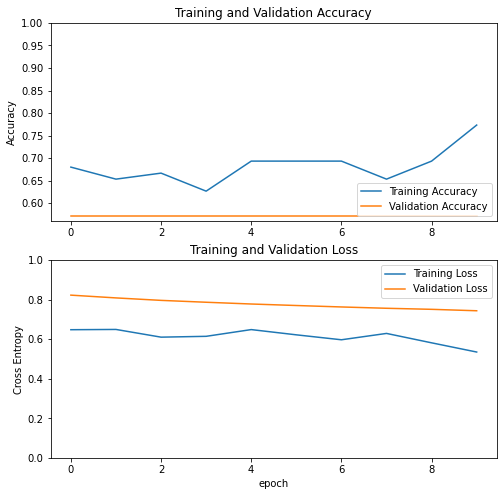

In [22]:
# Learning curve of the training and validation accuracy & loss MobileNet base model as a feature extractor.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


## Tuning
In this section we will further train few top layers of the pre-trained mobilenetv2 base model along the classifier we added this will make sure that weights adopted to our features.

In [23]:
# unfreeze the base_model and set the bottom layers to be un-trainable
base_model.trainable = True


In [24]:
# look into see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# as we will fine-tune from this layer onwards
fine_tune_at = 100

# freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  154


In [25]:
# As we are training a much larger model and want to readapt the pretrained weights
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])


/home/ari/anaconda3/envs/first/lib/python3.8/site-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [26]:
# little insights about model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [27]:
# continue training the model
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 10/20
3/3 [==============================] - 4s 462ms/step - loss: 0.5630 - accuracy: 0.7067 - val_loss: 0.5894 - val_accuracy: 0.5714
Epoch 11/20
3/3 [==============================] - 1s 226ms/step - loss: 0.3824 - accuracy: 0.8533 - val_loss: 0.5650 - val_accuracy: 0.6429
Epoch 12/20
3/3 [==============================] - 1s 220ms/step - loss: 0.2575 - accuracy: 0.9333 - val_loss: 0.4992 - val_accuracy: 0.7143
Epoch 13/20
3/3 [==============================] - 1s 189ms/step - loss: 0.1976 - accuracy: 0.9467 - val_loss: 0.4252 - val_accuracy: 0.7857
Epoch 14/20
3/3 [==============================] - 1s 221ms/step - loss: 0.1716 - accuracy: 0.9333 - val_loss: 0.4437 - val_accuracy: 0.7857
Epoch 15/20
3/3 [==============================] - 1s 218ms/step - loss: 0.1667 - accuracy: 0.9333 - val_loss: 0.3257 - val_accuracy: 0.7857
Epoch 16/20
3/3 [==============================] - 1s 215ms/step - loss: 0.1552 - accuracy: 0.9733 - val_loss: 0.3463 - val_accuracy: 0.7857
Epoch 17/20
3

In [28]:
## Storing the accuracy and validation accuracy
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


## Final model evaluation

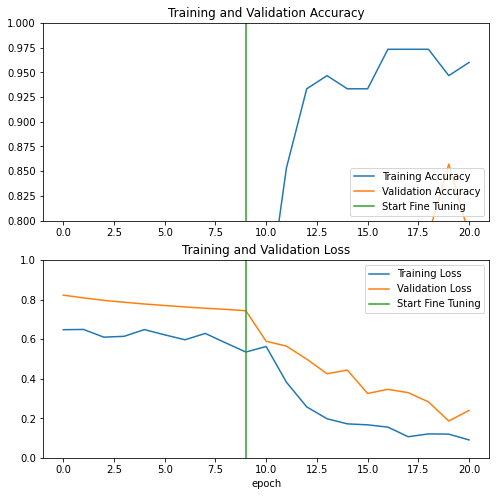

In [29]:
## Plotting the accuracy and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [30]:
# verifying the performance of the model using validation set
loss, accuracy = model.evaluate(validation_dataset)
print('Test accuracy :', accuracy)


1/1 [==============================] - 0s 81ms/step - loss: 0.2396 - accuracy: 0.7857
Test accuracy : 0.7857142686843872


## Finally some predictions using our test data 

Predictions:
 [0 1 1 1 0 0]
Labels:
 [0 0 1 1 0 1]


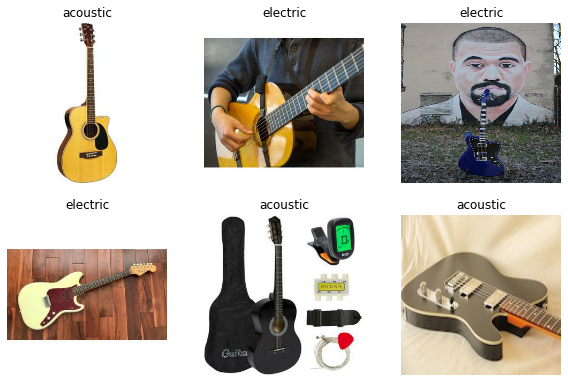

In [31]:
# Further evaluation and predicitons on the test data
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(6):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")


## Summary 
We can see that there is a gradual increase in accuracy of the model after fine tuning but still we can see there are some miclassifications from the test data maybe this could be increased by training for more epochs.